### Explore Batter Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

#Sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble

#Display
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)
%matplotlib inline

In [2]:
batter_profiles = pd.read_csv('milb_batter_summaries.csv')
batter_seasons = pd.read_csv('milb_all_batter_seasons.csv')

In [3]:
len(batter_profiles.milb_id.unique())

17525

__Helper Functions__

Add Useful Data Fields

In [4]:
def add_season_number(df):
    first_year = pd.DataFrame()
    first_year['FirstYear'] = df.groupby(['milb_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['SeasonNumber'] = df['Year'] - df['FirstYear'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df

def add_success_year(df):
    success_year = pd.DataFrame()
    success_year['FirstYear'] = df.groupby(['milb_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['SeasonNumber'] = df['Year'] - df['FirstYear'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df


Add Stat Calulation Functions

In [5]:
## Batting Average
# Number of Hits (divided by) Number of At Bats

# Calculate the number of single from other hit data
def calc_singles(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    return df

def calc_BA(df):
    ba_series = df['H']/df['AB']
    return ba_series
    
## Slugging Percentage
# Number of (Singles + [2 x Doubles] +[ 3 x Triples] + [4 x Home Runs]) divided by At Bats  
def calc_SLG(df):
    slg_series = (df['1B'] + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']
    return slg_series

## On Base Percentage
# (Hits + Walks + Hit-By-Pitch) divided by (At Bats + Walks+ Hit-By-Pitch + Sac Flys)
def calc_OBP(df):
    obp_series = (df['H'] + df['BB'] + df['HBP']) \
        / (df['AB'] + df['BB'] + df['HBP']+df['SF']) 
    return obp_series

## On Base Plus Slugging 
def calc_OPS(df):
     # On Base Plus Slugging 
    ops_series = calc_OBP(df) + calc_SLG(df)
    return ops_series

Add Aggregation Function

In [6]:
# Aggregate year by year stats into full career data.
# Requires the recalculation of rate based stats from their definitions.
def make_season_stats(df):
    
    counting_stats = ['G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO','TB', 'GDP', 'HBP','SH', 'SF', 'IBB']
    
    
    if 'LevNum' in df.columns:
        df['LevWeight'] = df['LevNum']*df['PA']
    
    
    # Make groupby object to only do aggregation once
    grouped_obj = df.groupby(['milb_id','Year'])
    
    df_grouped = grouped_obj.sum()
    
    df_grouped['1B'] = calc_singles(df_grouped)
    
    # Batting Average 
    df_grouped['BA'] = calc_BA(df_grouped)
    
    # On Base Percentage
    df_grouped['OBP'] = calc_OBP(df_grouped)
    
    # Slugging Percentage
    df_grouped['SLG'] = calc_SLG(df_grouped)
    
    # On Base Plus Slugging 
    df_grouped['OPS'] = calc_OPS(df_grouped)
    
    # Other BIO 
    # Fields where max is most important 
    test_fields = ['Age','FirstYear',
                   'SeasonNumber','SuccessYear']
    for tf in test_fields:
        if tf in df_grouped.columns:
            df_grouped[tf] = grouped_obj[tf].max()
            
    # fields where min is most importand
    test_fields2 = ['AgeDif']
    for tf in test_fields2:
        if tf in df_grouped.columns:
            df_grouped[tf] = grouped_obj[tf].min()
                  
    # Minor League Level Attributs
    if 'LevNum' in df.columns:
        df_grouped['LevWeighted'] = df_grouped['LevWeight']/df_grouped['PA']
        
        df_grouped['LevCount'] = grouped_obj.count()['Lev']
        df_grouped.drop('LevWeight', axis=1, inplace=True)
    
    df_grouped.reset_index(inplace=True)
    
    return df_grouped


Function for creating rate stats

In [7]:
def make_rate_stats(df):
    
    df['HR_rate'] = df['HR']/df['PA']
    df['BB_rate'] = df['BB']/df['PA']
    df['SO_rate'] = df['SO']/df['PA']
    df['IBB_rate'] = df['IBB']/df['PA']
    df['SB_rate'] = df['SB']/df['PA'] #None standard definition
    df['SB_percentage'] = df['SB']/(df['SB']+df['CS'])
    df.loc[np.isnan(df['SB_percentage']),['SB_percentage']] = 0
    
    df['GDP_rate'] = df['GDP']/df['PA']
    df['SH_rate'] = df['SH']/df['PA']
    df['SF_rate'] = df['SF']/df['PA']
    df['HBP_rate'] = df['HBP']/df['PA']
    
    
    df['SB_percentage']
    
    return df

Function to Convert Player Profile into Useful Features

__Filtering and Aggregation__

In [8]:
batter_seasons_filt = deepcopy(batter_seasons)

# Drop Aggregated Seasons. Will Recompute
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt.Tm.str.contains('Teams') == False]

In [9]:
# Map Each League to a level
lev_dict = {'FRk':0,'Rk':1,'A-':2,'A':3,'A+':4,'AA':5,'AAA':6}
level_map = pd.Series(batter_seasons_filt.loc[:,('Lev')].map(lev_dict))
batter_seasons_filt['LevNum'] = level_map

# Drop Leagues that are "Atypical"
weird_leagues = ['Ind','Rk','FRk','WRk','FgW','Fal','Fgn','Wtr']
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['Lev'].isin(weird_leagues) == False]
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['Lg'] != 'MEX']

In [10]:
# Remove Players Who had their first season before 1990.
batter_seasons_filt = add_season_number(batter_seasons_filt)
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['FirstYear'] > 1990]

batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['FirstYear'] < 2012]

In [11]:
# Remove Seasons that occured after player made the majors
majors_df = batter_seasons_filt[
    batter_seasons_filt.Lev == 'MLB'][['milb_id','Year']]

mlb_debuts = majors_df.groupby('milb_id').min().reset_index()
mlb_debuts.rename(columns={'Year':'SuccessYear'},inplace=True)

batter_seasons_filt = batter_seasons_filt.merge(
    mlb_debuts, how = 'left',on= 'milb_id')

batter_seasons_filt = batter_seasons_filt[
    (batter_seasons_filt['SuccessYear'] > batter_seasons_filt['Year']) | 
    pd.isnull(batter_seasons_filt['SuccessYear'])] 


In [12]:
batter_seasons_total = make_season_stats(batter_seasons_filt)
batter_seasons_total = make_rate_stats(batter_seasons_total)

In [13]:
## Add dependent variable
batter_seasons_total = batter_seasons_total.merge(
    batter_profiles.loc[:,['milb_id','mlb']],
    how = 'left',
    on = 'milb_id')

In [14]:
bst_test = deepcopy(batter_seasons_total)

In [15]:
bst_test = bst_test.loc[bst_test['SeasonNumber'] == 2,:]
bst_test = bst_test.loc[bst_test['PA'] > 150,:]

### Model Stuff

Start by using Features from Season Data

In [52]:
test_cols = ['milb_id','LevWeighted','AgeDif','PA',
             'BA','OBP','SLG','HR_rate',
             'BB_rate','SO_rate','IBB_rate',
             'SB_rate','SB_percentage','GDP_rate',
             'SH_rate','HBP_rate']

X1 = bst_test.loc[:,test_cols]
y1 = bst_test.loc[:,['mlb']]

X1_train, X1_test, y1_train, y1_test = model_selection.train_test_split(
    X1, y1, test_size=0.3)

y1_train = np.ravel(y1_train)
y1_test = np.ravel(y1_test)

In [53]:
# Baseline Prediction
#sum(y1)/len(y1)
baseline1 = sum(y1_train)/len(y1_train)
baseline1

0.25130365022061774

Try a few algorithms "out of the box," to see how they do.

In [128]:
pred_dict = {}
model_dict = {}

lm1 = linear_model.LogisticRegression()
lm1.fit(X1_train.iloc[:,1:],y1_train)
pred_dict['lm1'] = lm1.predict_proba(X1_test.iloc[:,1:])
model_dict['lm1'] = lm1

rf1 = ensemble.RandomForestClassifier(
    n_estimators=500,
    min_samples_leaf = 5)
rf1.fit(X1_train.iloc[:,1:],y1_train)
pred_proba_rf1 = rf1.predict_proba(X1_test.iloc[:,1:])
pred_dict['rf1'] = rf1.predict_proba(X1_test.iloc[:,1:])
model_dict['rf1'] = rf1

gb1 = ensemble.GradientBoostingClassifier(
    learning_rate=.01,
    subsample=0.3,
    max_depth=4,
    n_estimators = 500)
gb1.fit(X1_train.iloc[:,1:],y1_train)
pred_dict['gb1'] = gb1.predict_proba(X1_test.iloc[:,1:])
model_dict['gb1'] = gb1

Precision and recall at 50% cutoff

In [129]:
summary_list = []
for k in pred_dict.keys():
    temp_dict = {}
    temp_dict['model'] = k
    temp_dict['logloss'] = metrics.log_loss(y1_test,pred_dict[k])
    temp_dict['accuracy'] = metrics.accuracy_score(
        y1_test,
        np.round(pred_dict[k][:,1]))
    p, r, f, s = metrics.precision_recall_fscore_support(
        y1_test,
        np.round(pred_dict[k][:,1]),
        labels = [0,1])
    
    temp_dict['precision'] = p[1]
    temp_dict['recall'] = r[1]
    temp_dict['f1'] = f[1]
    temp_dict['summprt'] = s[1]
    summary_list.append(temp_dict)

In [130]:
results1_df = pd.DataFrame(summary_list)
results1_df.set_index(results1_df.model,inplace = True)
results1_df

,accuracy,f1,logloss,model,precision,recall,summprt
model,,,,,,,
lm1,0.807206,0.511848,0.416999,lm1,0.658537,0.418605,516
rf1,0.805335,0.496368,0.418206,rf1,0.661290,0.397287,516
gb1,0.806270,0.529545,0.416386,gb1,0.640110,0.451550,516


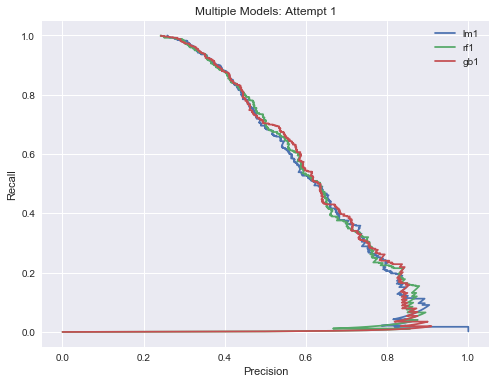

In [136]:
leg = []
plt.figure(figsize=(8, 6))
for k in pred_dict.keys():
    prec, recall, thresholds = metrics.precision_recall_curve(
        y1_test,pred_dict[k][:,1])

    plt.plot(prec[0:-1], recall[0:-1])
    leg.append(k)
    
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.legend(leg)
plt.title('Multiple Models: Attempt 1')

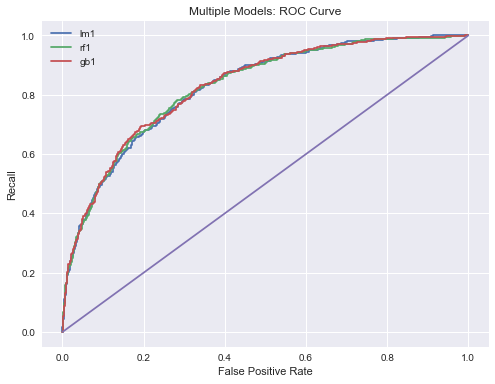

In [143]:
leg = []
plt.figure(figsize=(8, 6))
for k in pred_dict.keys():
    fpr, tpr, thresholds = metrics.roc_curve(y1_test,pred_dict[k][:,1])
    plt.plot(fpr, tpr)
    leg.append(k)
    
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))    
plt.legend(leg)
plt.title('Multiple Models: ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')

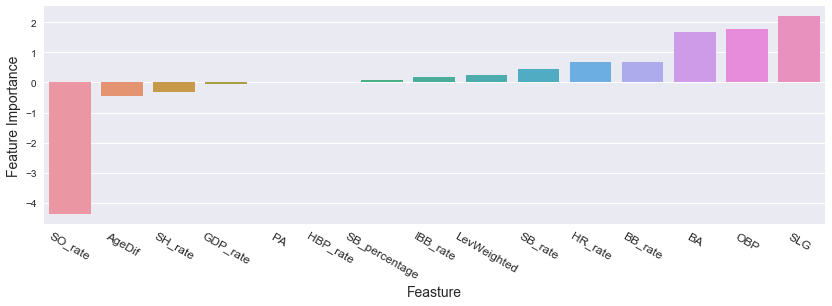

In [136]:



f_Series = pd.Series(lm1.coef_[0],index = X1.columns[1:]).sort_values()

plt.figure(figsize=(14, 4))
g = sns.barplot(x = f_Series.index,y = f_Series)
g.set_xticklabels(f_Series.index, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feasture',size=14);


In [148]:
pred_dict

{'gb1': array([[ 0.92392875,  0.07607125],
        [ 0.71180256,  0.28819744],
        [ 0.81244084,  0.18755916],
        ..., 
        [ 0.45978784,  0.54021216],
        [ 0.89235729,  0.10764271],
        [ 0.44067186,  0.55932814]]), 'lm1': array([[ 0.92602457,  0.07397543],
        [ 0.60039909,  0.39960091],
        [ 0.78478723,  0.21521277],
        ..., 
        [ 0.23253915,  0.76746085],
        [ 0.88131551,  0.11868449],
        [ 0.38414418,  0.61585582]]), 'rf1': array([[ 0.91992173,  0.08007827],
        [ 0.71088749,  0.28911251],
        [ 0.7787929 ,  0.2212071 ],
        ..., 
        [ 0.37378938,  0.62621062],
        [ 0.80211968,  0.19788032],
        [ 0.45137946,  0.54862054]])}

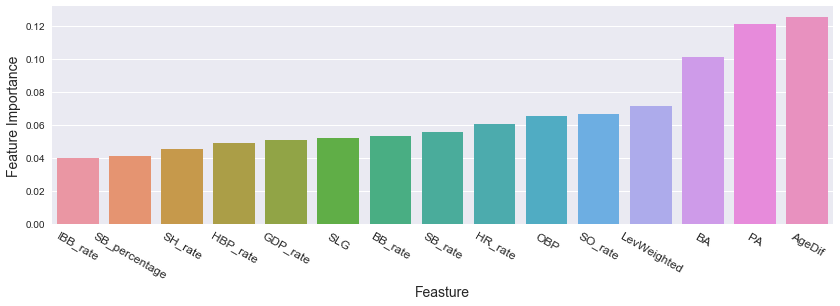

In [139]:
f_Series = pd.Series(rf1.feature_importances_,index = X1.columns[1:]).sort_values()

plt.figure(figsize=(14, 4))
g = sns.barplot(x = f_Series.index,y = f_Series)
g.set_xticklabels(f_Series.index, rotation=-30,size=12)
plt.ylabel('Feature Importance',size=14);
plt.xlabel('Feasture',size=14);

In [141]:
pred_proba_df = pd.DataFrame(pred_proba_rf1,index = X1_test.index)
pred_proba_df['id'] = X1_test['milb_id']
pred_proba_df['truth'] = y1_test
pred_proba_df.sort_values(1,ascending = False)

,0,1,id,truth
24157,0.0,1.0,navarr001dio,1
21303,0.0,1.0,mathis001jef,1
8445,0.0,1.0,delluc001dav,1
19610,0.0,1.0,lockwo001mic,0
5231,0.0,1.0,caruso001mic,1
33427,0.0,1.0,swishe001nic,1
6145,0.0,1.0,cirill001jef,1
19746,0.0,1.0,longor001eva,1
1344,0.0,1.0,aubrey001rob,1
20407,0.0,1.0,magee001wen,1


In [147]:
lm1

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)